In [1]:
#--------------------------------  IMPORTS  --------------------------------
import os
import sys
import sqlite3
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import logging
logging.basicConfig(format='[%(asctime)s] %(levelname)s: %(message)s',level=logging.INFO,datefmt='%m/%d/%Y %I:%M:%S')

In [2]:
#--------------------------------  MACROS  --------------------------------

PLANETS = ["jupiter","neptune","uranus"]
FREQUENCIES = ["low","mid","high"]

SIMULATION = "simulation0"
DATABASE = "../simulations"
DEBUG = False

In [3]:
class DataReader():
    def __init__(self,database=None,debug=False):
        if database is None:
            raise ValueError("Database name must not be None")
        self.database = database
        self.debug = debug
        self.conn = None
        self.c = None
        self._connect(self.database)
    
    def _connect(self,db):
        if self.conn is None:
            if self.debug:
                print(f"Connecting to SQL Database {db}...")
            self.conn = sqlite3.connect(f'{db}.db')
            self.c = self.conn.cursor()
        else:
            if self.debug:
                print("Connection already established.")
    def _disconnect(self):
        if self.debug:
            print(f"Disconnecting from SQL Database {self.database}...")
        self.conn.close()
    
    def __repr__(self):
        string = f"""
        Data Reader class:
        - Connected to database: {self.database}
        - SQL Connection: {self.conn}
        - Debug mode: {self.debug}
        """
        return string
    
    def get_all_tables(self):
        if self.debug:
            print("Querying all tables from database...")
        self.c.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
        tables=(self.c.fetchall())
        return [item[0] for item in tables]
    
    def get_table(self,sim_name="simulation0",order="planet",order_type="ASC"):
        if not isinstance(order,str):
            raise TypeError("Order key must be a string")
        if not isinstance(sim_name,str):
            raise TypeError("Table name must be a string")
        if not isinstance(order_type,str):
            raise TypeError("Order type must be a string")
        order_type = order_type.upper()
        if order_type not in ["ASC","DESC"]:
            raise ValueError(f"Invalid order type {str(order_type)}. Must be ASC or DESC")

        sql_statement = f'''SELECT * FROM {sim_name} ORDER BY {order} {order_type}'''
        data = self.c.execute(sql_statement)
        rows = self.c.fetchall()
        return rows
    
    def get_item(self,sim_name,planet,frequency,inclination=0.0):
        table = self.get_table(sim_name)
        for item in table:
            if item[0] == planet.capitalize() and item[1] == frequency.lower() and item[2] == inclination:
                return item
        return None

class Data():
    def __init__(self):
        for p in PLANETS:
            exec("self.%s = {}" % p)
            for f in FREQUENCIES:
                command = "self.%s['%s'] = {'incl_error' : [],'ampl_error' : [],'fwhm_error' : []}" % (p,f)
                exec(command)
    
    def fill_from_SQL(self,data):
        for d in data:
            self.append_data(d[0],d[1],d[2],incl_error=d[3])
            self.append_data(d[0],d[1],d[2],ampl_error=d[4])
            self.append_data(d[0],d[1],d[2],fwhm_error=d[5])
    
    def append_data(self,planet,frequency,inclination,incl_error = None,ampl_error = None, fwhm_error = None):
        if incl_error is not None:
            key = "incl_error"
            if ampl_error is not None or fwhm_error is not None:
                raise SyntaxError("Invalid syntax in append data.")
        if ampl_error is not None:
            key = "ampl_error"
            if incl_error is not None or fwhm_error is not None:
                raise SyntaxError("Invalid syntax in append data.")
        if fwhm_error is not None:
            key = "fwhm_error"
            if ampl_error is not None or incl_error is not None:
                raise SyntaxError("Invalid syntax in append data.")
        command = "self.%s['%s']['%s'].append( (%f,%f) )" % (planet.lower(),frequency,key,inclination,eval(key))
        exec(command)
        
    def get_inclination_list(self):
        mylist = [item[0] for item in eval("self.jupiter['low']['incl_error']")]
        return mylist
    
    def get_single_list(self,planet,frequency,parameter):
        if not parameter in ["incl_error","ampl_error","fwhm_error"]:
            raise ValueError(f"Invalid parameter {parameter}.")
        mylist = [item[1] for item in eval(f"self.{planet.lower()}['{frequency}']['{parameter}']")]
        return mylist
    

In [4]:
#--------------------------------  LOAD DATA  --------------------------------

reader = DataReader(database=DATABASE,debug=DEBUG)
mydata = Data()
mydata.fill_from_SQL(reader.get_table(sim_name=SIMULATION,order="planet"))

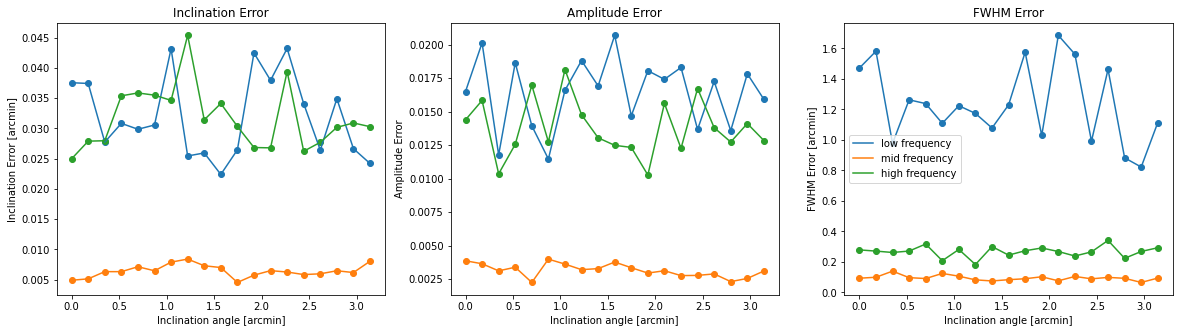

In [6]:
#--------------------------------  VISUALIZATION  --------------------------------
myplanet = "uranus"
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, sharex = True,figsize = (20,5))
ax1.set_xlabel("Inclination angle [arcmin]")
ax2.set_xlabel("Inclination angle [arcmin]")
ax3.set_xlabel("Inclination angle [arcmin]")
ax1.set_ylabel("Inclination Error [arcmin]")
ax2.set_ylabel("Amplitude Error")
ax3.set_ylabel("FWHM Error [arcmin]")
ax1.set_title("Inclination Error")
ax2.set_title("Amplitude Error")
ax3.set_title("FWHM Error")

for f in FREQUENCIES:
    ax1.scatter(mydata.get_inclination_list() , mydata.get_single_list(myplanet,f,"incl_error"))
    ax1.plot(mydata.get_inclination_list() , mydata.get_single_list(myplanet,f,"incl_error"))
    
    ax2.scatter(mydata.get_inclination_list() , mydata.get_single_list(myplanet,f,"ampl_error"))
    ax2.plot(mydata.get_inclination_list() , mydata.get_single_list(myplanet,f,"ampl_error"),)
    
    ax3.scatter(mydata.get_inclination_list() , mydata.get_single_list(myplanet,f,"fwhm_error"))
    ax3.plot(mydata.get_inclination_list() , mydata.get_single_list(myplanet,f,"fwhm_error"),label = f"{f} frequency")
    
plt.legend(prop={'size': 10})


#---
fig = go.Figure(
    data=[
    go.Table(
        header=dict(values=['Frequency [GHz]','Inclination', 'Amplitude', 'FWHM']),
        cells=dict(values=[
            ["low - 40","mid - 166","high - 402"],
            [
            "{:.5f}".format(np.mean(mydata.get_single_list(myplanet,"low","incl_error"))),
            "{:.5f}".format(np.mean(mydata.get_single_list(myplanet,"mid","incl_error"))),
            "{:.5f}".format(np.mean(mydata.get_single_list(myplanet,"high","incl_error")))
            ],
            [
            "{:.5f}".format(np.mean(mydata.get_single_list(myplanet,"low","ampl_error"))),
            "{:.5f}".format(np.mean(mydata.get_single_list(myplanet,"mid","ampl_error"))),
            "{:.5f}".format(np.mean(mydata.get_single_list(myplanet,"high","ampl_error")))
            ],
            [
            "{:.5f}".format(np.mean(mydata.get_single_list(myplanet,"low","fwhm_error"))),
            "{:.5f}".format(np.mean(mydata.get_single_list(myplanet,"mid","fwhm_error"))),
            "{:.5f}".format(np.mean(mydata.get_single_list(myplanet,"high","fwhm_error")))
            ]
        ])
    )]
)
fig.update_layout(title_text=myplanet.capitalize(),title_x=0.5)
fig.update_layout(width=800, height=270)
fig.show()
